In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import keras
from keras.applications.resnet_v2 import ResNet152V2
import numpy as np
import cv2
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K 
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense, GlobalAveragePooling2D

Using TensorFlow backend.


In [3]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/drive/My Drive/data/train",target_size=(224,224),classes =['non_park','park'],batch_size=32)
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/drive/My Drive/data/val", target_size=(224,224),classes = ['non_park','park'],batch_size = 32)
test = ImageDataGenerator()
testsample = test.flow_from_directory(directory="/content/drive/My Drive/data/test", target_size=(224,224),classes = ['non_park','park'],batch_size = 10)

Found 6000 images belonging to 2 classes.
Found 584 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
base_model=ResNet152V2(include_top=False)

234553344/234545216 [==============================] - 7s 0us/step


In [ ]:
base_model.summary()

In [6]:
x = base_model.output

In [7]:
x = GlobalAveragePooling2D()(x)

In [8]:
predictions = Dense(2, activation='softmax')(x)

In [9]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

In [11]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(filepath="/content/drive/My Drive/data/resnet152V2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

In [14]:
hist = model.fit_generator(steps_per_epoch=187,generator=traindata, validation_data= testdata, validation_steps=18,epochs=20,callbacks=[checkpoint,early])

Epoch 1/20
187/187 [==============================] - 3050s 16s/step - loss: 0.3637 - accuracy: 0.8401 - val_loss: 1.3938 - val_accuracy: 0.4948

Epoch 00001: val_accuracy improved from -inf to 0.49479, saving model to /content/drive/My Drive/data/resnet152V2.h5
Epoch 2/20
187/187 [==============================] - 548s 3s/step - loss: 0.2551 - accuracy: 0.8978 - val_loss: 0.1836 - val_accuracy: 0.8895

Epoch 00002: val_accuracy improved from 0.49479 to 0.88949, saving model to /content/drive/My Drive/data/resnet152V2.h5
Epoch 3/20
187/187 [==============================] - 542s 3s/step - loss: 0.1885 - accuracy: 0.9253 - val_loss: 0.4725 - val_accuracy: 0.7663

Epoch 00003: val_accuracy did not improve from 0.88949
Epoch 4/20
187/187 [==============================] - 545s 3s/step - loss: 0.1295 - accuracy: 0.9527 - val_loss: 0.1086 - val_accuracy: 0.9275

Epoch 00004: val_accuracy improved from 0.88949 to 0.92754, saving model to /content/drive/My Drive/data/resnet152V2.h5
Epoch 5/20

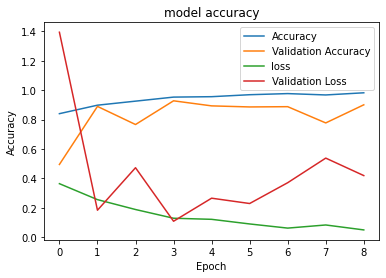

In [15]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [16]:
test_imgs , test_labels = next(testsample)
test_labels = test_labels[:,0]

In [17]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

Confusion matrix, without normalization
[[4 6]
 [2 8]]
              precision    recall  f1-score   support

    non_park       0.67      0.40      0.50        10
        park       0.57      0.80      0.67        10

    accuracy                           0.60        20
   macro avg       0.62      0.60      0.58        20
weighted avg       0.62      0.60      0.58        20



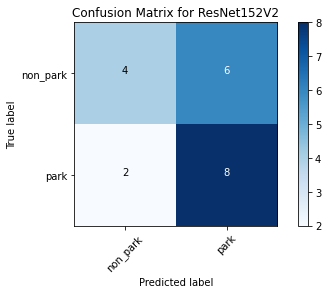

In [31]:
pred = model.predict_generator(testsample, verbose=0)
cm = confusion_matrix(y_true=testsample.classes, y_pred=np.argmax(pred, axis=-1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_plot_labels = ['non_park','park']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix for ResNet152V2')
print(classification_report(y_true=testsample.classes, y_pred=np.argmax(pred, axis=-1), target_names=['non_park','park']))